In [1]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
sys.path.append('../jax_healpix/')
from SPHT_jax import *
from utils import *
from reshape_utils import *
from astropy.table import Table

In [3]:
nside=32
l_max=nside*3

In [4]:
npix=hp.nside2npix(nside)
pw=hp.pixwin(nside,lmax=l_max)
l_h, m_h = hp.Alm.getlm(lmax=l_max)

In [5]:
#https://stackoverflow.com/questions/69070804/how-to-reduce-jax-compile-time-when-using-for-loop

In [6]:
cl=np.ones(nside*3)*1.e-5/(np.arange(nside*3)+1)
%time hmap=hp.synfast(cl,nside=nside)
# ipix=2*nside*(nside+1) +nside
# ipix=2*nside*(nside-1) -100
ipix=0
# hmap[ipix]=1
# hmap[npix//2:]=0

nt=nside
npix_t=2*nt*(nt+1)

# hmap[npix_t]=1

# hmap[np.int32(np.arange(npix_t))]+=np.arange(npix_t)*1.e-5
# hmap[npix_t:-npix_t]=np.arange(12*nside**2-2*npix_t)*1.e-6
# hmap[npix_t:npix_t+4*nside]=np.arange(4*nside)*1.e-5+1

# hmap[npix_t:-npix_t]-=hmap[npix_t:-npix_t].mean()
# hmap[:]=1

hmap2,indxs=reshape_maps(nside,np.atleast_2d(hmap))
mask=stack_maps(nside,None)
# hmap2=hmap2.at[:,:,1:].set(0)
# hmap=np.array(hmap2[:,mask][0])

CPU times: user 13.5 s, sys: 0 ns, total: 13.5 s
Wall time: 110 ms


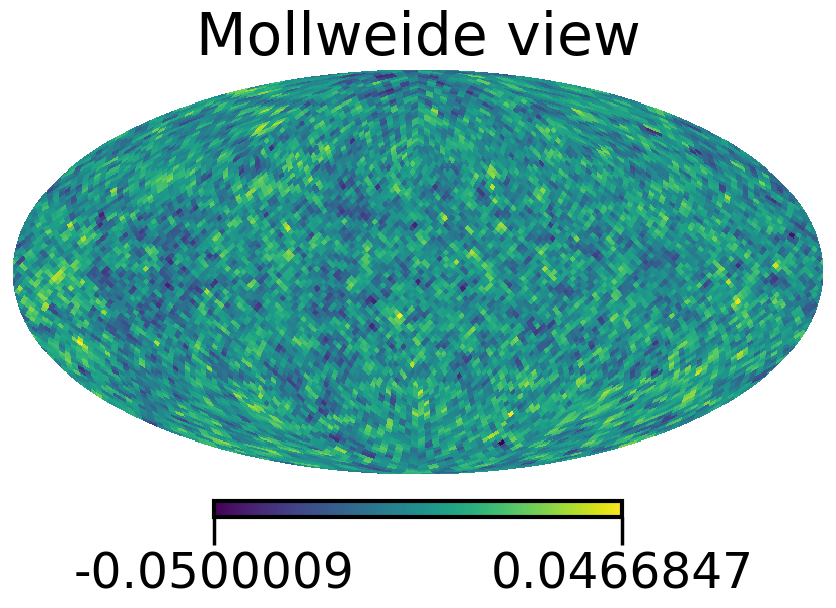

In [84]:
hp.mollview(hmap)

In [83]:
alm_hp=hp.map2alm(hmap,lmax=l_max,iter=0,)
alm_hp3=hp.map2alm(hmap,lmax=l_max,iter=3,)
cl_hp=hp.anafast(hmap,lmax=l_max,use_weights=False,iter=0)
cl_hp3=hp.anafast(hmap,lmax=l_max,use_weights=False,iter=3)

In [85]:
%time alm_t=map2alm(nside,l_max,0,{0:hmap2})
niter=3
%time alm_t3=map2alm_iter(nside,l_max,0,niter,{0:hmap2})

CPU times: user 9.89 ms, sys: 108 ms, total: 118 ms
Wall time: 212 ms
CPU times: user 3.52 s, sys: 28.3 ms, total: 3.55 s
Wall time: 853 ms


In [86]:
cl_t=alm2cl(l_max, alm_t[0])
cl_t=cl_t[0]

cl_t3=alm2cl(l_max, alm_t3[0])
cl_t3=cl_t3[0]

In [87]:
xx=np.isclose(cl_t,cl_hp)
np.all(xx),cl_t[~xx],cl_hp[~xx]

(True, DeviceArray([], dtype=float32), array([], dtype=float64))

In [88]:
xx=np.isclose(cl_t3,cl_hp3)
np.all(xx),cl_t3[~xx],cl_hp3[~xx]

(True, DeviceArray([], dtype=float32), array([], dtype=float64))

[]

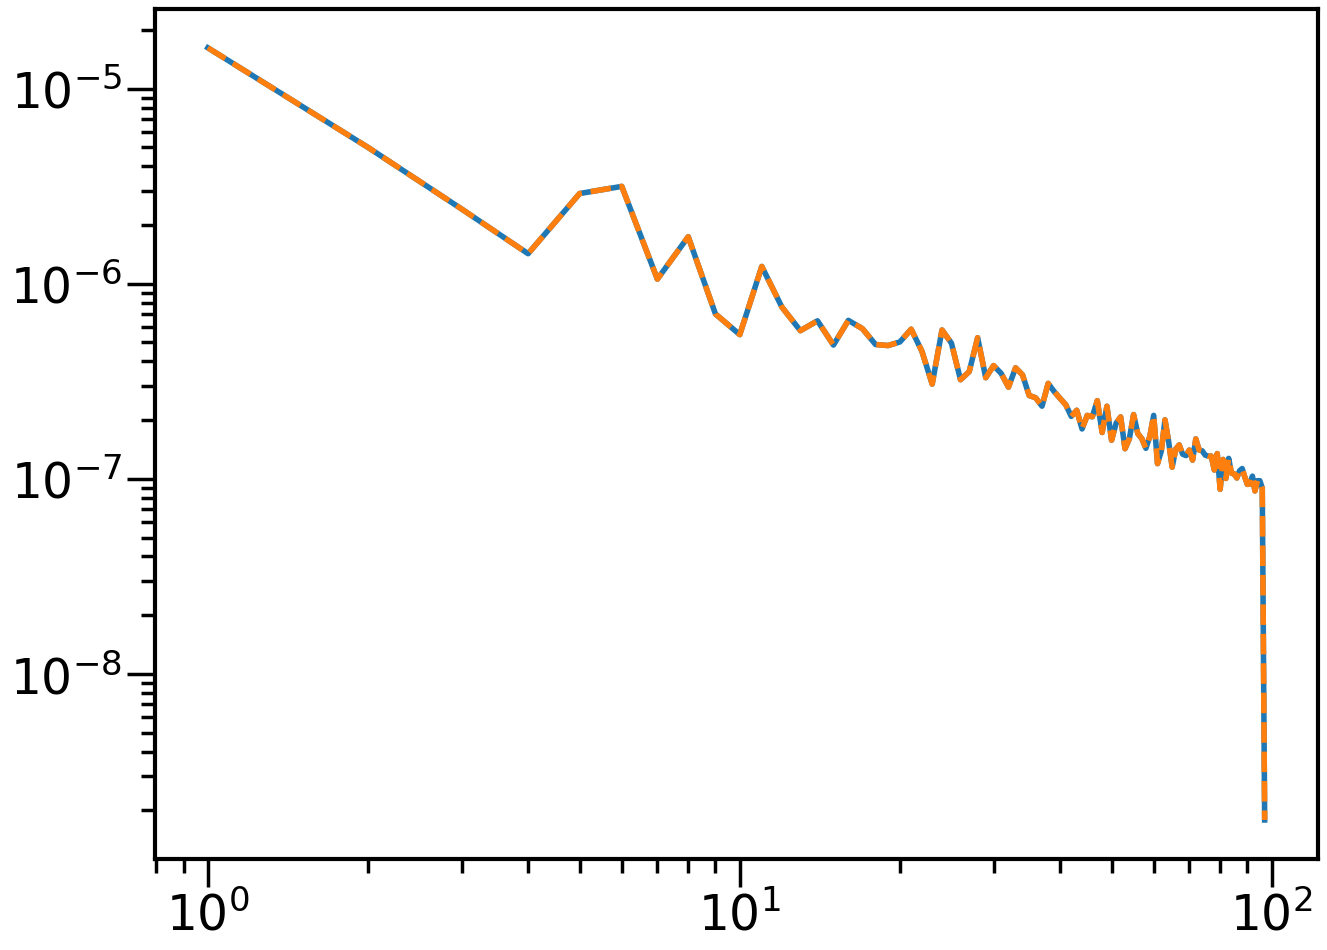

In [89]:
plot(jnp.arange(l_max+1)+1,cl_t3)
plot(jnp.arange(l_max+1)+1,cl_hp3,'--')
loglog()
# ylim(1.e-1,10)

Text(0, 0.5, 'Cl ratio')

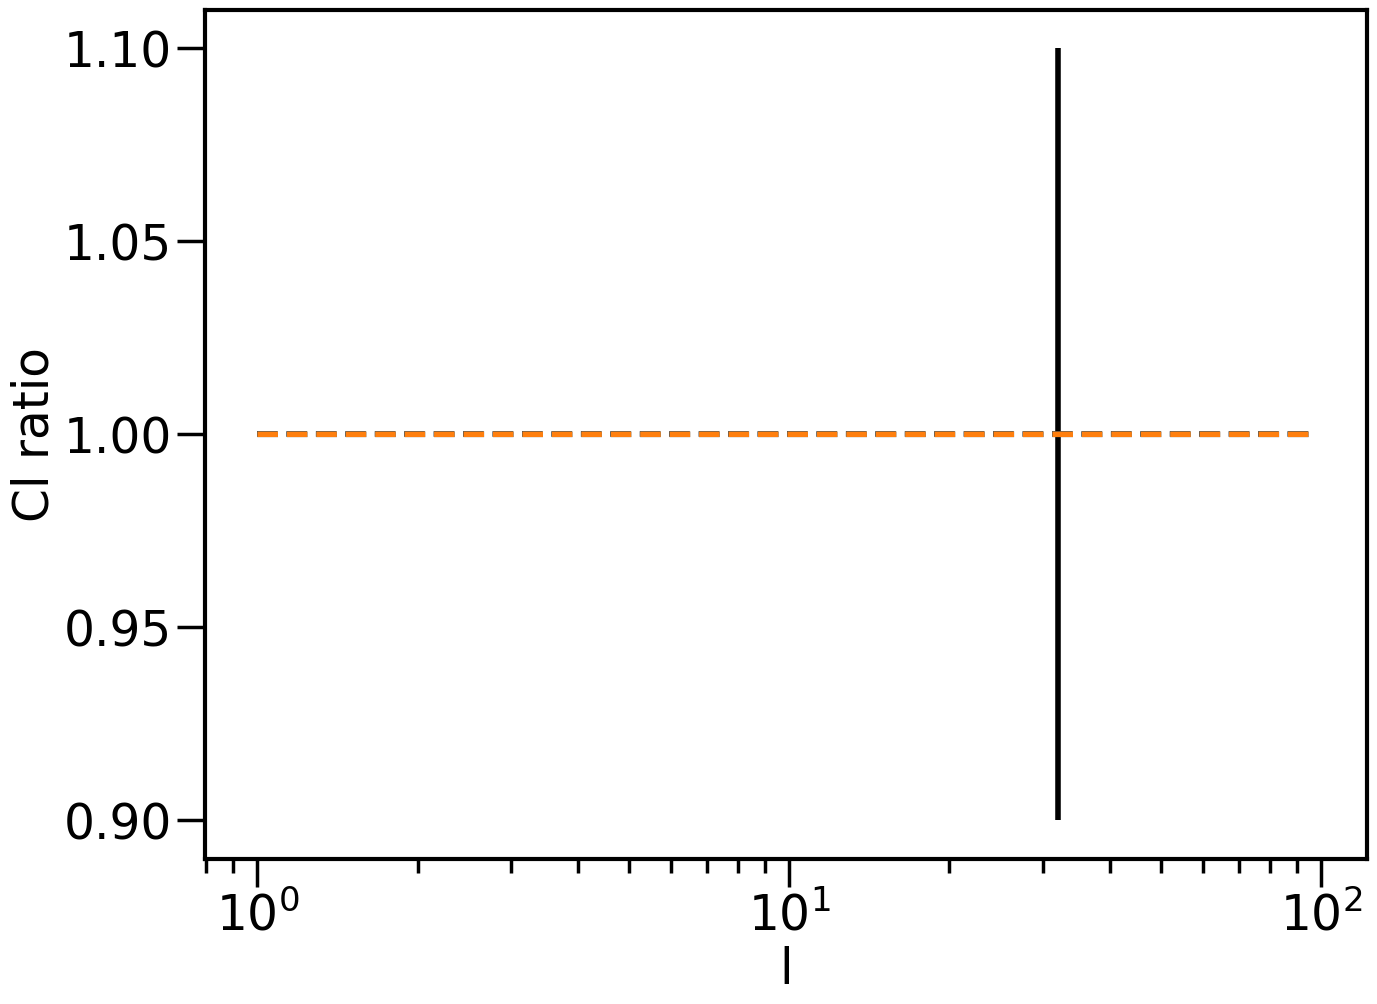

In [91]:
plot(jnp.arange(l_max+1)+1,cl_t/cl_hp,'--')
plot(jnp.arange(l_max+1)+1,cl_t3/cl_hp3,'--')
hlines(1,1,l_max+1,ls='--',color='k',zorder=-1)
vlines(nside,.9,1.1,color='k')
xlabel('l')
xscale('log')
ylabel('Cl ratio')
# ylim(1.e-1,10)
# ylim(.9,1.1)

In [18]:
jnp.all(jnp.isfinite(alm_t[0]))

DeviceArray(True, dtype=bool)

In [19]:
alm_t2=stack_alm(l_max,alm_t,order='m')
alm_t23=reshape_alm(l_max,alm_t2[0]) #reverse
np.all(alm_t23==alm_t[0])

In [93]:
xx=np.isclose(np.real(alm_t2[0][0]),np.real(alm_hp))
r=np.real(alm_t2[0][0])[~xx]/np.real(alm_hp)[~xx]
d=np.real(alm_t2[0][0])[~xx]-np.real(alm_hp)[~xx]
np.all(xx),r,d,np.real(alm_hp)[~xx],np.real(alm_t2[0][0])[~xx]

(True,
 DeviceArray([], dtype=float64),
 DeviceArray([], dtype=float64),
 array([], dtype=float64),
 DeviceArray([], dtype=float32))

In [94]:
xx=np.isclose(np.imag(alm_t2[0][0]),np.imag(alm_hp))
np.all(xx),np.imag(alm_t2[0][0])[~xx]/np.imag(alm_hp)[~xx]

(True, DeviceArray([], dtype=float64))

In [95]:
l_i=0
m_i=0
x=np.logical_and(m_h==m_i,l_h==l_i)

alm_t[0][0][l_i,m_i],alm_hp[x]

(DeviceArray(-0.00402382+0.j, dtype=complex64), array([-0.00402382+0.j]))

In [51]:
map_hp=hp.alm2map(alm_hp,nside,pol=False)
map_hp3=hp.alm2map(alm_hp3,nside,pol=False)

In [100]:
map_t=alm2map(nside,l_max,0,alm_t)
map_t3=alm2map(nside,l_max,0,alm_t3)
# mm_i=alm2map(nside,l_max,0,alm_t_i)

In [101]:
mask=stack_maps(nside,map_t[0])

In [102]:
map_t_s=map_t[0][:,mask]
map_t3_s=map_t[0][:,mask]
# mm2_i=mm_i[0][:,mask]

In [118]:
diff_map=np.array(map_t_s[0]-hmap)
diff_map3=np.array(map_t3_s[0]-hmap)

diff_map_hp=map_hp-hmap

In [119]:
diff_map.mean(),diff_map.std()

(3.9785212420302874e-08, 0.0014238751823414796)

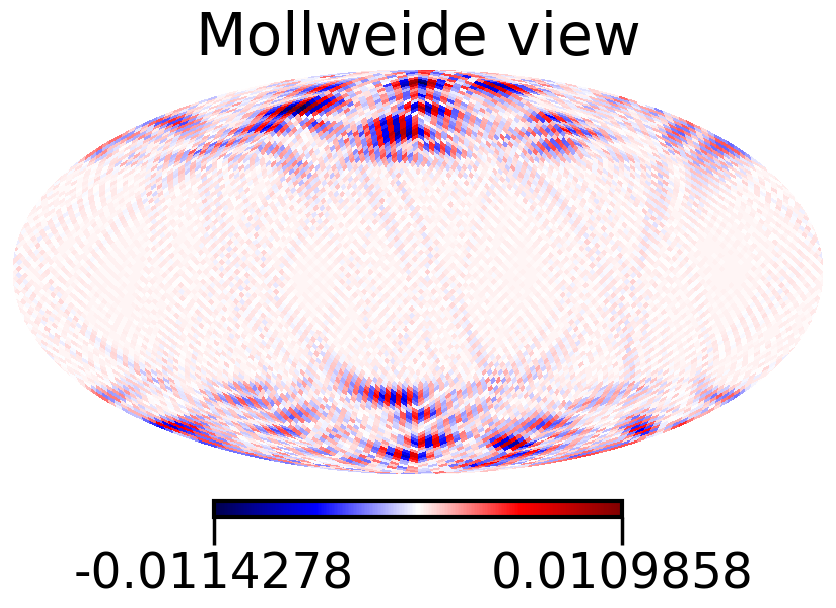

In [120]:
hp.mollview(diff_map,cmap='seismic')#,min=-2,max=2)

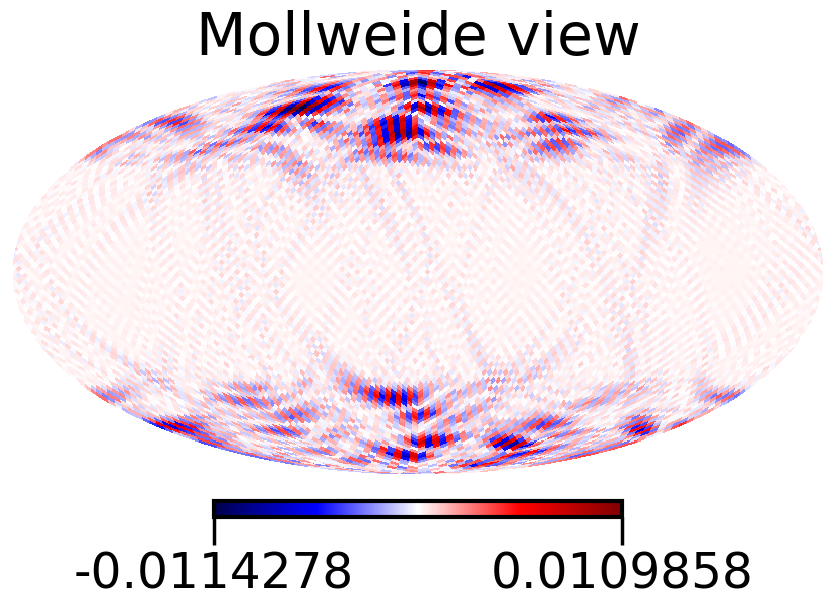

In [122]:
hp.mollview(diff_map_hp,cmap='seismic')#,min=-2,max=2)

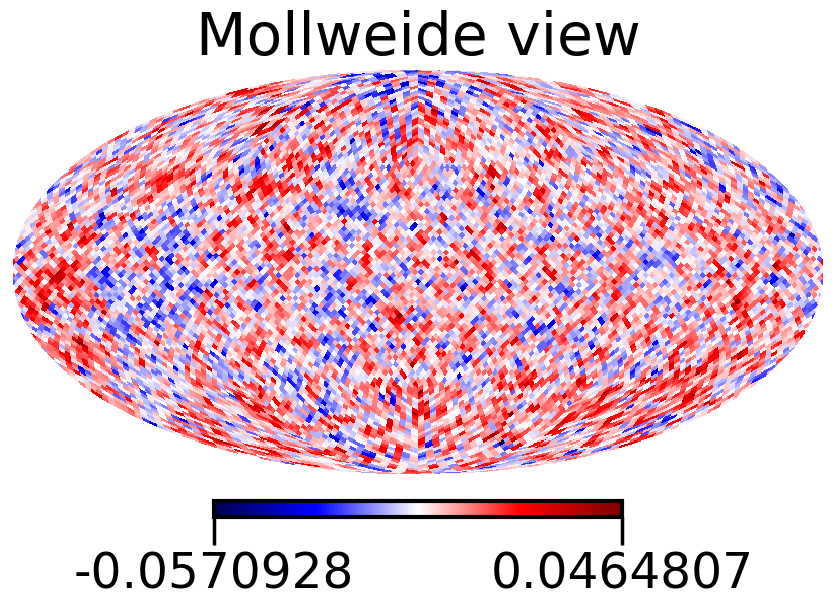

In [123]:
hp.mollview(map_t_s[0],cmap='seismic')

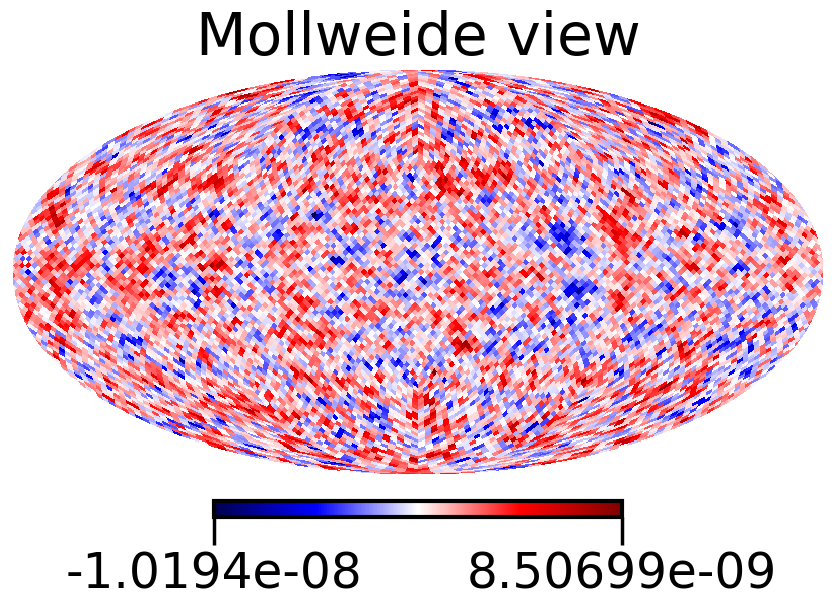

In [124]:
hp.mollview(map_t_s[0]-map_hp,cmap='seismic')

In [110]:
cl_ht=hp.anafast(np.array(map_t_s[0]),hmap,lmax=l_max)
cl_hhp=hp.anafast(np.array(map_hp),hmap,lmax=l_max)

cl_dm=hp.anafast(diff_map,lmax=l_max)
cl_dmh=hp.anafast(diff_map,hmap,lmax=l_max)

[]

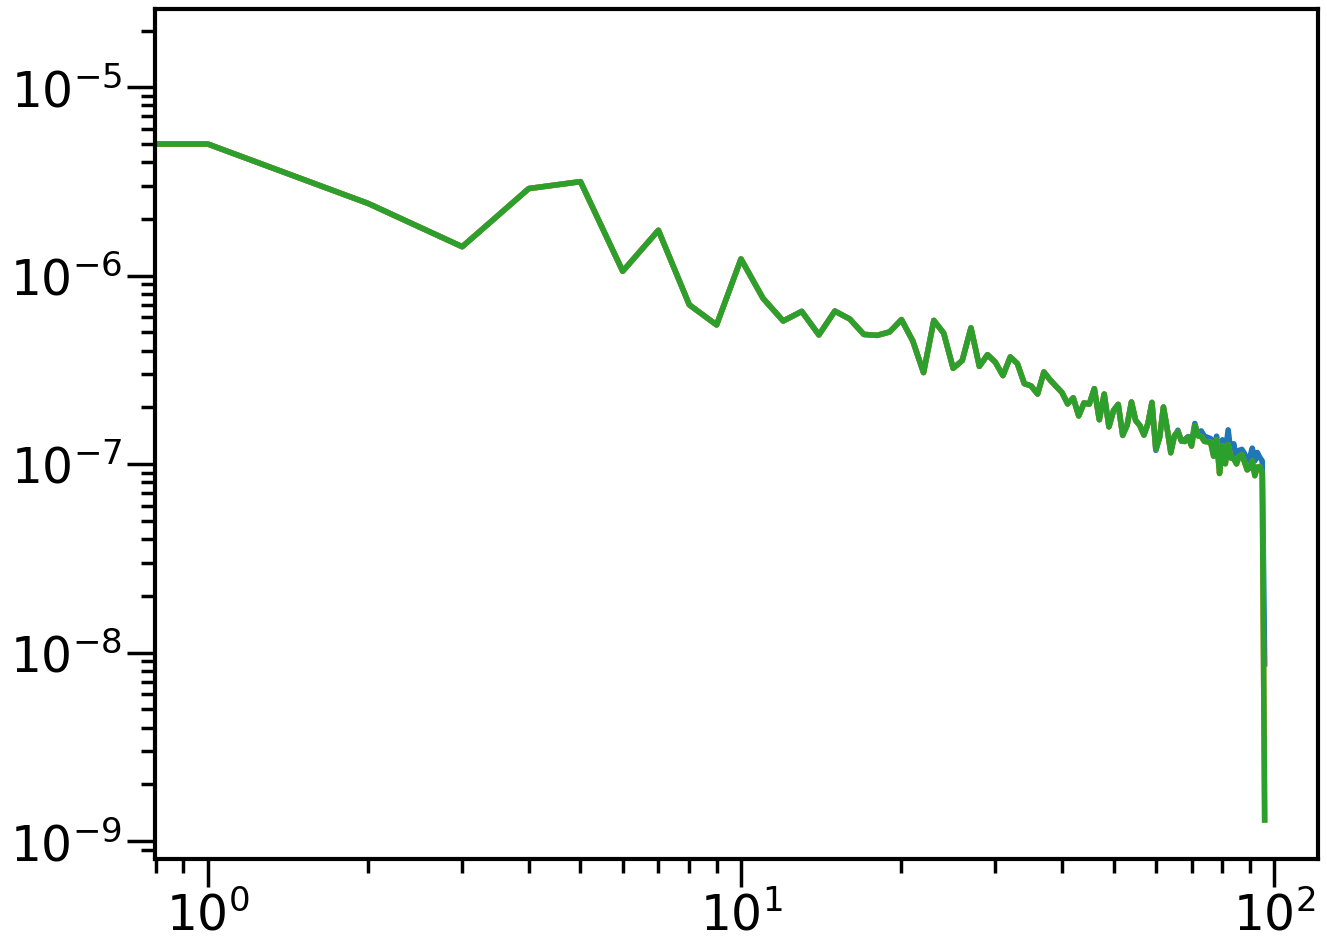

In [115]:
plot(cl_hp)
plot(cl_hhp)
plot(cl_ht)
loglog()
# ylim(1.e-9,1.e-5)
# ylim(1.e-1,2)

[]

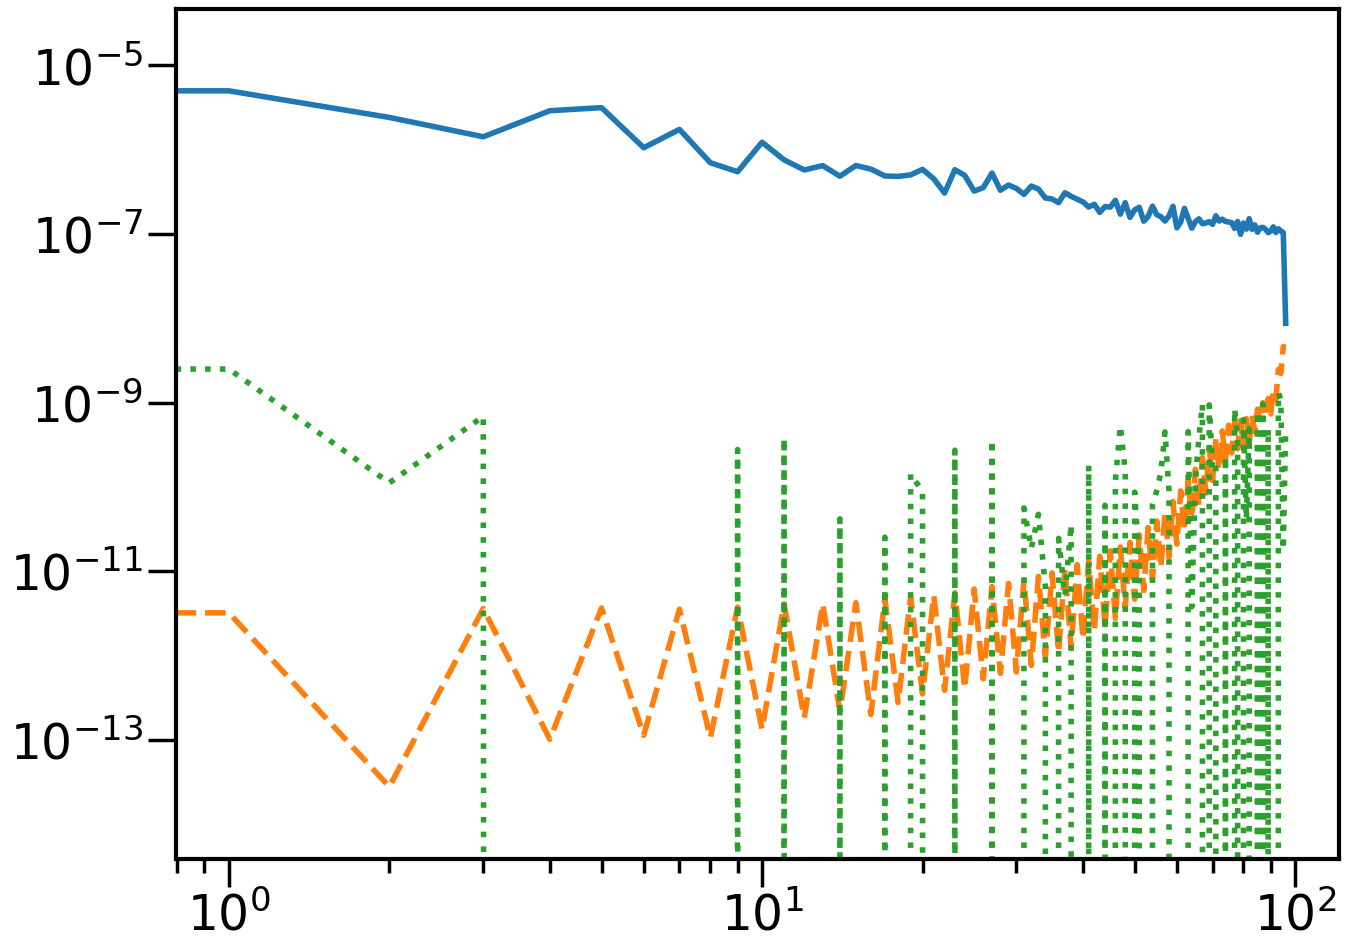

In [116]:
plot(cl_hp)
plot(cl_dm,'--')
plot(cl_dm2*-1,':')
loglog()